# Comparision of convergence speed and accuracy of SNNs over standard FNNs with Batch Normalisation

## Data Preprocessing : MNIST dataset

In [12]:
import torch
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from keras.datasets.mnist import load_data
from sklearn.preprocessing import StandardScaler
sns.set_theme()

In [13]:
# load (and normalize) mnist dataset
(trainX, trainy), (testX, testy) = load_data()
s = StandardScaler()
s.fit(trainX.reshape(-1, 28 * 28))
trainX = s.transform(trainX.reshape(-1, 28 * 28)).astype(np.float32)
testX = s.transform(testX.reshape(-1, 28 * 28)).astype(np.float32)

## Defining models : SNN and MLP( with BatchNorm)

In [6]:
class SELU(nn.Module):

    def __init__(self):
        super(SELU, self).__init__()
        # the parameters alpha and lambda_ are obtained in getSELUparameters.ipynb
        self.alpha = 1.6732632423543772848170429916717
        self.lambda_ = 1.0507009873554804934193349852946

    def forward(self, x):
        # SELU activation function
        # piecewise activation function
        # x < 0: lambda_ * alpha * (exp(x) - 1)
        # x >= 0: lambda_ * x
        return self.lambda_ * (torch.maximum(torch.tensor([0], device=x.device), x) + 
                               torch.minimum(torch.tensor([0], device=x.device),self.alpha * (torch.exp(x) - 1))
                               )


class SNN(nn.Module):

    def __init__(self, input_dim=28 * 28, hidden_dim=28 * 28, output_dim=10, depth=8):
        super(SNN, self).__init__()

        model = []
        # add layers equal to the depth of the network
        for _ in range(depth):
            # each layer is a linear layer followed by a SELU activation
            model += [nn.Linear(input_dim, hidden_dim), SELU()]
        
        # add the final layer as a linear layer followed by a log softmax
        # this is to ensure that the output is a probability distribution
        model += [nn.Linear(hidden_dim, output_dim), nn.LogSoftmax(dim=-1)]
        self.network = nn.Sequential(*model)

    def forward(self, x):
        return self.network(x)


class MLP(nn.Module):

    def __init__(self, input_dim=28 * 28, hidden_dim=28 * 28, output_dim=10, depth=8):
        super(MLP, self).__init__()

        model = []
        # add layers equal to the depth of the network
        for _ in range(depth):
            # each layer is a linear layer followed by a Batch Normalisation layer
            model += [nn.Linear(input_dim, hidden_dim), nn.ReLU(), torch.nn.BatchNorm1d(hidden_dim)]

        # add the final layer as a linear layer followed by a log softmax
        # this is to ensure that the output is a probability distribution
        model += [nn.Linear(hidden_dim, output_dim), nn.LogSoftmax(dim=-1)]
        self.network = nn.Sequential(*model)

    def forward(self, x):
        return self.network(x)

## Weights initialisation and train loop

In [17]:
def train(model, optimizer, dataset, loss_fct=torch.nn.NLLLoss(), device='cpu', nb_epochs=25):
    training_loss = []

    # Loop over epochs
    for _ in tqdm(range(nb_epochs)):
        batch_loss = []
        # Loop over batches in the dataset
        for batch in dataset:
            # Extract features (x) and labels (y) from the batch
            x, y = batch

            # Forward pass: compute predicted log probabilities
            log_prob = model(x.to(device).reshape(-1, 28 * 28))

            # Calculate the loss between predicted log probabilities and actual labels
            loss = loss_fct(log_prob, y.to(device))

            # Zero the gradients to avoid accumulation
            optimizer.zero_grad()

            # Backward pass
            loss.backward()
            optimizer.step()

            # Append the current batch's loss to the list
            batch_loss.append(loss.item())

        # Compute the mean training loss for the current epoch
        epoch_loss = np.mean(batch_loss)

        # Append the mean training loss to the list for all epochs
        training_loss.append(epoch_loss)

    # Return the list of training losses for each epoch
    return training_loss

def _init_weights(module, init_gain=1.):
    # initialise weights using lecun normal form for selu
    # initialise weights using MSRA initialisation for MLP batch normalisation
    if isinstance(module, nn.Linear):
        # lecun Normal :    mean=0 and var=1/n where n is the number of input features
        # MSRA         :    mean=0 and var=2/n where n is the number of input features
        module.weight.data.normal_(mean=0.0, std=np.sqrt(init_gain / module.weight.data.shape[0]))
        if module.bias is not None:
            module.bias.data.zero_()

## Model training

In [ ]:
device = 'cuda'
nb_epochs = 2000
dataset = DataLoader([[trainX[i], trainy[i]] for i in range(trainX.shape[0])], batch_size=128, shuffle=True)

# consider the depth of the network as a hyperparameter
depth_parameters = [8, 16, 32]

# train the snn models with varying depths and plot the training error
training_loss_snn = {}
for depth in depth_parameters:
    model = SNN(depth=depth).to(device)
    # intialise weights using lecun normal form
    model.apply(_init_weights)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
    training_loss_snn[depth] = train(model, optimizer, dataset, device=device, nb_epochs=nb_epochs)

# train the mlp models with varying depths and plot the training error
training_loss_mlp = {}
for depth in depth_parameters:
    model = MLP(depth=depth).to(device)
    # intialise weights using MSRA initialisation
    model.apply(lambda x: _init_weights(x, init_gain=2.))
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
    training_loss_mlp[depth] = train(model, optimizer, dataset, device=device, nb_epochs=nb_epochs)

## Plotting Epochs vs Loss

In [9]:
def plot():
    # plot the training error and save the image
    fontsize = 14
    plt.plot(training_loss_mlp[8], color=plt.cm.bwr([0.05]), label='BatchNorm Depth 8')
    plt.plot(training_loss_mlp[16], color=plt.cm.bwr([0.15]), label='BatchNorm Depth 16')
    plt.plot(training_loss_mlp[32], color=plt.cm.bwr([0.25]), label='BatchNorm Depth 32')
    plt.plot(training_loss_snn[8], color=plt.cm.bwr([0.75]), label='SNN Depth 8')
    plt.plot(training_loss_snn[16], color=plt.cm.bwr([0.85]), label='SNN Depth 16')
    plt.plot(training_loss_snn[32], color=plt.cm.bwr([0.95]), label='SNN Depth 32')
    plt.yscale("log")
    plt.xlabel("Iterations", fontsize=fontsize)
    plt.ylabel("Training Error", fontsize=fontsize)
    plt.legend()
    plt.savefig('snn_vs_mlp.png', bbox_inches='tight')

In [16]:
plot()

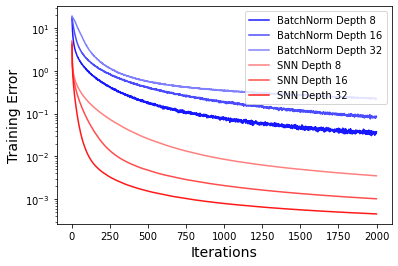

In [2]:
# display the final image
from IPython.display import display
from PIL import Image as PILImage

image_path = './snn_vs_mlp.png'

# Open the image
original_image = PILImage.open(image_path)

# Display the image with the white background
display(original_image)

### FNNs with batch normalization exhibit high variance due to perturbations. In contrast, SNNs do not suffer from high variance as they are more robust to perturbations and learn faster